<a href="https://colab.research.google.com/github/SukhandeepKaurShergill/Transfer-Learning/blob/main/Copy2_of_dog_breed_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Connecting google drive with google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. if you have zipped file, 
Extract zip file

In [ ]:
import zipfile
with zipfile.ZipFile('dog-breed-identification.zip', 'r') as zip_ref:
    zip_ref.extractall('dog_breed')


#3. import all required libraries for deep learning and vgg16

In [2]:
from keras import regularizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16

# 4. Pandas and Numpy for data structures and util fucntions

In [3]:
import numpy as np
#pip install pandas
import pandas as pd
from numpy.random import rand

# 5. Scikit Imports 

In [4]:
pd.options.display.max_colwidth = 600
from sklearn.model_selection import train_test_split

# 6. Matplot Imports

In [5]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# 7. Display functions

In [6]:

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# 8. Go to train folder

In [7]:

train_folder = '/content/drive/MyDrive/Thapar_summer_school/vgg16/train/'
#test_folder = '/content/test/'

#9. pandas display data frames as tables

In [8]:
data_labels = pd.read_csv('/content/drive/MyDrive/Thapar_summer_school/vgg16/labels.csv')


#10. display the columns

In [9]:
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


#11. Extract some intial values of dataset

In [10]:
data_labels=data_labels[:3000]

# 12. Access labels 

In [11]:
target_labels = data_labels['breed']


#13. check the number of classes

In [12]:
len(set(target_labels))

120

# 14. Prepare Labels
Deep Learning models work with one hot encoded outputs or target variables. We utilize pandas to prepare one hot encoding for the labels.

In [13]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)


#15. Print the encoded labels

In [14]:
print(labels_ohe.shape)
print(labels_ohe[:2])

(3000, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


# 16. Create another colomn of named image_path to acces the images from dataset

In [15]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/drive/MyDrive/Thapar_summer_school/vgg16/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/drive/MyDrive/Thapar_summer_school/vgg16/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/drive/MyDrive/Thapar_summer_school/vgg16/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/drive/MyDrive/Thapar_summer_school/vgg16/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/Thapar_summer_school/vgg16/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


# 17. Prepare Train-Test Datasets
 We use a 70-30 split to prepare the two dataset.
 convert images data into numpy arrays

In [16]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(224, 224))
                       ) for img 
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

#18. check the shape of data

In [17]:
train_data.shape

(3000, 224, 224, 3)

#19. divide the data into training and testing

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

# 20. check shape of training and testing data

In [19]:
x_train.shape, x_test.shape

((2100, 224, 224, 3), (900, 224, 224, 3))

#21.  Prepare training and validation data from training data

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)


#22. check shape of training and validation data

In [21]:
x_train.shape, x_val.shape

((1785, 224, 224, 3), (315, 224, 224, 3))

#23. Prepare target variables for train, test and validation datasets

for Training labels

In [22]:
y_train_ohe = pd.get_dummies(y_train, sparse=True)
y_train_ohe = np.asarray(y_train_ohe)

# 24. for testing labels

In [23]:
y_test_ohe = pd.get_dummies(y_test, sparse=True)
y_test_ohe = np.asarray(y_test_ohe)

#25. For validation labels

In [24]:
y_val_ohe = pd.get_dummies(y_val, sparse=True)
y_val_ohe = np.asarray(y_val_ohe)



#26. check shape of all labels

In [25]:
y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((1785, 120), (900, 120), (315, 120))

#27. define batch size 

In [26]:
BATCH_SIZE = 12

# Data Augmentation
Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ImageDataGenerator utility from keras

# 28. Create train generator.

In [27]:

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

# 29. Create validation generator

In [28]:

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

#30. Get the vgg16 model so we can do transfer learning

In [29]:

base_vgg = VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

# Using Readymade model without any fine tuning only change last layer i.e. classification layer

#31. Add a global spatial average pooling layer

In [30]:

out = base_vgg.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

#32. define model

In [31]:
model = Model(inputs=base_vgg.input, outputs=predictions)

#33. only if we want to freeze layers

In [32]:

for layer in base_vgg.layers:
    layer.trainable = False

# 34. Compile the model

In [33]:
 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 



#35. check model summary

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#36. Train the model

In [36]:

batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=100,
                              verbose=1)

Epoch 1/100
 87/148 [================>.............] - ETA: 6:56 - loss: 4.8203 - accuracy: 0.0106

KeyboardInterrupt: ignored

#37. save the model

In [ ]:
model.save('dog_breed_vgg16.hdf5')

# Load the trained model

In [37]:
import keras
model=keras.models.load_model('/content/drive/MyDrive/Thapar_summer_school/vgg16/dog_breed_vgg16.hdf5')

#38. Plot the results

NameError: ignored

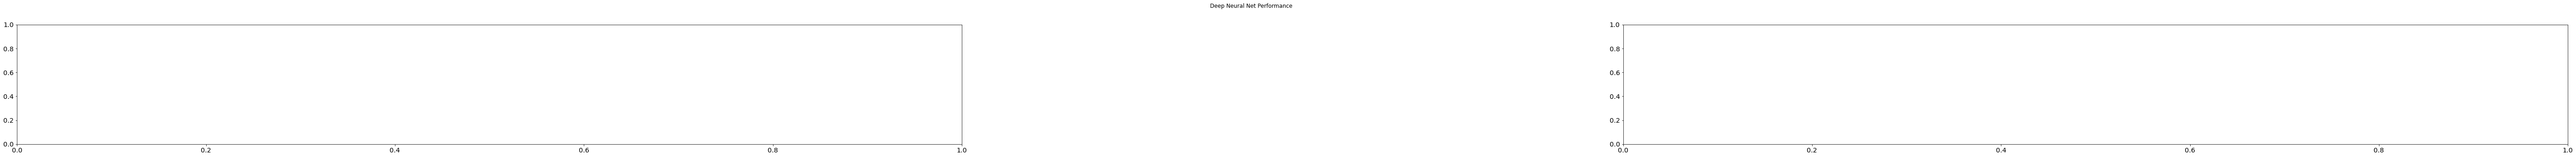

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.7)

epochs = list(range(1,101))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# 39. scaling test features for testing

In [39]:

x_test /= 255.

#40. call model for predictions

In [40]:
test_predictions = model.predict(x_test)
test_predictions

array([[3.3189313e-05, 2.4618816e-03, 1.6864258e-05, ..., 1.9171132e-02,
        1.6188623e-01, 4.5842156e-04],
       [1.7469238e-06, 2.4805756e-04, 3.0023124e-05, ..., 4.7736824e-02,
        2.5813884e-05, 2.4510389e-06],
       [2.8432826e-06, 1.4104212e-04, 2.7385388e-06, ..., 2.1049043e-05,
        4.7994312e-04, 1.7474184e-05],
       ...,
       [4.9801940e-08, 1.6892821e-08, 1.4990131e-05, ..., 1.7418640e-03,
        1.9854529e-05, 2.1008772e-09],
       [6.8486070e-06, 2.9612897e-04, 5.2169646e-04, ..., 1.7324165e-01,
        1.0732670e-02, 1.1502679e-04],
       [2.8847946e-06, 1.1860656e-06, 4.8439382e-03, ..., 2.3826016e-03,
        2.5211034e-06, 4.7670028e-06]], dtype=float32)

#41. display prediction corresponding to class label 

In [41]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000033,0.002462,0.000017,1.428039e-01,9.153614e-05,3.339837e-05,5.627767e-05,3.133041e-04,1.016954e-05,2.186359e-05,...,8.464764e-04,1.032040e-04,5.045370e-04,5.521233e-06,3.693197e-03,0.001255,0.000175,0.019171,0.161886,0.000458
1,0.000002,0.000248,0.000030,1.415264e-05,6.044317e-03,2.651518e-05,2.608036e-05,3.913946e-02,6.839918e-03,2.088521e-04,...,9.942961e-07,4.749590e-03,1.549082e-02,5.582855e-04,1.137534e-02,0.000558,0.000004,0.047737,0.000026,0.000002
2,0.000003,0.000141,0.000003,7.364438e-07,2.344973e-08,3.168456e-07,3.980613e-07,1.741310e-09,6.723095e-07,1.436166e-07,...,3.923922e-05,2.823775e-08,1.544325e-09,1.055861e-07,5.389397e-07,0.002029,0.001062,0.000021,0.000480,0.000017
3,0.005769,0.000050,0.000026,1.386232e-03,1.843103e-03,6.139613e-05,1.599230e-05,4.189389e-05,8.293787e-05,3.000639e-06,...,2.472305e-03,4.608396e-03,2.429677e-06,3.010824e-04,2.642315e-05,0.000021,0.000438,0.000437,0.007311,0.000050
4,0.000621,0.000184,0.000027,1.001023e-03,7.307397e-05,3.839084e-03,1.092677e-04,1.040855e-05,8.371511e-03,1.915526e-04,...,1.722281e-03,1.205289e-05,4.349005e-07,4.435585e-05,3.950631e-06,0.000890,0.000005,0.000005,0.000175,0.000017


#42. Display predictions for first 10 test values

In [42]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['wire-haired_fox_terrier',
 'ibizan_hound',
 'borzoi',
 'bouvier_des_flandres',
 'bernese_mountain_dog',
 'papillon',
 'irish_setter',
 'cardigan',
 'bouvier_des_flandres',
 'old_english_sheepdog']

#43. calculate the accuracy of whole test data

In [43]:
#Making prediction
y_pred=model.predict(x_test)
y_true=np.argmax(y_test_ohe,axis=1)

44. Evaluate the model

In [44]:
loss, accuracy = model.evaluate(x_test, y_test_ohe, verbose=0)

#45. print the results

In [45]:
print(loss)
print(accuracy)

2.347381353378296
0.4377777874469757


#46. print the classification report

In [46]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
#target_names=['class 0', 'class 1', 'class 2','class 3','class 4']
#print(classification_report(y_true, y_pred_bool, target_names=target_names))
print(classification_report(y_true, y_pred_bool))

15/15 [==============================] - 461s 30s/step
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.83      0.56      0.67         9
           2       0.20      0.17      0.18         6
           3       0.75      0.30      0.43        10
           4       0.38      0.50      0.43         6
           5       0.67      0.29      0.40         7
           6       0.33      0.22      0.27         9
           7       0.32      0.60      0.41        10
           8       0.12      0.38      0.19         8
           9       0.57      0.44      0.50         9
          10       0.56      0.45      0.50        11
          11       0.71      0.45      0.56        11
          12       0.33      0.33      0.33         6
          13       0.67      0.67      0.67         9
          14       0.36      0.44      0.40         9
          15       0.50      0.29      0.36         7
          16       0.43   